<a href="https://colab.research.google.com/github/fumio125/ou_dip/blob/master/ou_dip_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np  # PythonのOpenCVでは、画像はnumpyのarrayとして管理される
from google.colab.patches import cv2_imshow # colab内で画像表示関数がうまく動かないので、パッチが提供されている

# Googleドライブへのマウント
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/ou_dip/"

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ou_dip


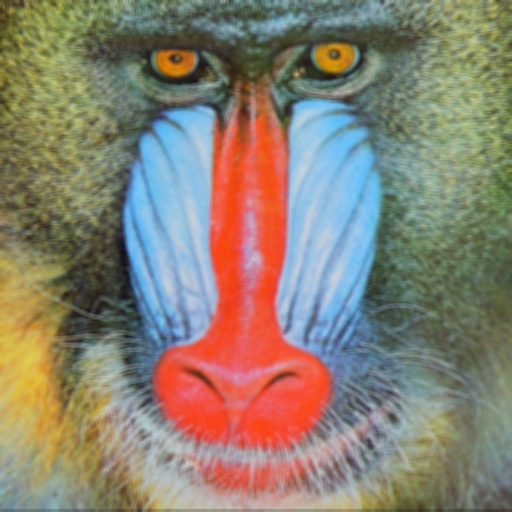

In [5]:
# 自分でカーネルを作る例

img = cv2.imread("sample.jpg") # 画像読み込み

kernel = np.ones((5,5),np.float32)/25 # 5x5平均化フィルタ
dst = cv2.filter2D(img,-1,kernel) # ddepth=-1とした場合、入出力のchannel数はおなじになる

cv2_imshow(dst)

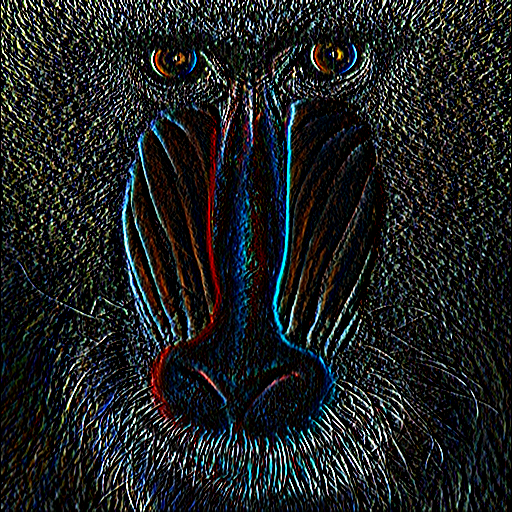

In [6]:
# OpenCV組み込み関数の例

img = cv2.imread("sample.jpg") # 画像読み込み
dst = cv2.Sobel(img,-1,1,0) # dx,dyで、x,y各方向の微分の次元を指定

cv2_imshow(dst)